In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
import ast
from tqdm import tqdm
import pickle

In [3]:
tqdm.pandas()

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
songs = pd.read_csv('./data/ten_g_500_modeling_12filt_uncomp.csv', sep='\t')

In [110]:
songs.columns[:36].tolist()

['id',
 'genre',
 'track_name',
 'preview_url',
 'location',
 'filename',
 'artist',
 'artist_uri',
 'album',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'energy_calc',
 'rms_calc',
 'mfcc_calc',
 'mean_energy',
 'std_energy',
 'min_energy',
 'max_energy',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'max_rms',
 'std_rms',
 'median_rms',
 'min_rms']

In [5]:
songs.drop(columns='Unnamed: 0', inplace=True)

In [8]:
songs['energy_calc'] = songs['energy_calc'].progress_apply(lambda x: np.array(ast.literal_eval(x)))
songs['rms_calc'] = songs['rms_calc'].progress_apply(lambda x: np.array(ast.literal_eval(x)))
songs['mfcc_calc'] = songs['mfcc_calc'].progress_apply(lambda x: np.array(ast.literal_eval(x)))
songs['mfcc_mean'] = songs['mfcc_mean'].progress_apply(lambda x: np.array(ast.literal_eval(x)))
songs['mfcc_min'] = songs['mfcc_min'].progress_apply(lambda x: np.array(ast.literal_eval(x)))
songs['mfcc_max'] = songs['mfcc_max'].progress_apply(lambda x: np.array(ast.literal_eval(x)))

100%|██████████| 4999/4999 [00:00<00:00, 18510.66it/s]


In [22]:
features = songs.columns[24:].drop(['mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max'])

In [89]:
X = songs[features]
y = songs['genre']

In [25]:
def running_models(X, y, scaled=False, c=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    
    # MODELING WITH SCALED FEATURES #
    
    # Scale the features
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # Creating a df to display results
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model_sc = SVC(C=c, kernel='rbf', degree=3)
    model_sc.fit(X_train_sc, y_train)
    train_score = model_sc.score(X_train_sc, y_train)
    test_score = model_sc.score(X_test_sc, y_test)
    
    row = {'model': type(model_sc).__name__,
           'train_score' : train_score,
          'test_score' : test_score,
           'C': c,
          'scaled': True}
    model_df = model_df.append(row, ignore_index=True)
    
    # MODELING WITH UNSCALED FEATURES #
    
    model = SVC(C=c, kernel='rbf', degree=3)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
       'train_score' : train_score,
      'test_score' : test_score,
       'C': c,
      'scaled': False}
    model_df = model_df.append(row, ignore_index=True)
    return model_df

In [26]:
running_models(X, y, scaled=False)

,train_score,test_score,C,model,scaled
0,0.862097,0.6088,10.0,SVC,1.0
1,0.603894,0.5648,10.0,SVC,0.0


Interesting, it looks like **unscaled data leads to less overfitting**. With an accuracy of $\approx$ 56.5%, this `SVC` model is outperforming the model using Spotify's features by about 6%

### **Digging deeper into the model**

Let's recreate the less overfit model above and further explore the results

In [90]:
# Create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

# Scale the features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [91]:
model = SVC(C=10)

model.fit(X_train, y_train)

SVC(C=10)

In [92]:
cross_val_score(model, X_train, y_train, n_jobs=12)

array([0.55866667, 0.55466667, 0.584     , 0.536     , 0.5540721 ])

In [93]:
model.score(X_train, y_train)

0.6038943718324886

In [94]:
model.score(X_test, y_test)

0.5648

In [95]:
filename = './models/SVC_10g_model.sav'

In [96]:
# Learned how to pickle from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
pickle.dump(model, open(filename, 'wb'))

In [97]:
y_preds = model.predict(X_test)

In [98]:
categories = list(set(y_preds))
numbers = list(range(len(categories)))

In [99]:
results = X_test.copy()

In [100]:
results.loc[:, 'genre'] = y_test.copy()

In [101]:
results.loc[:, 'preds'] = y_preds.copy()

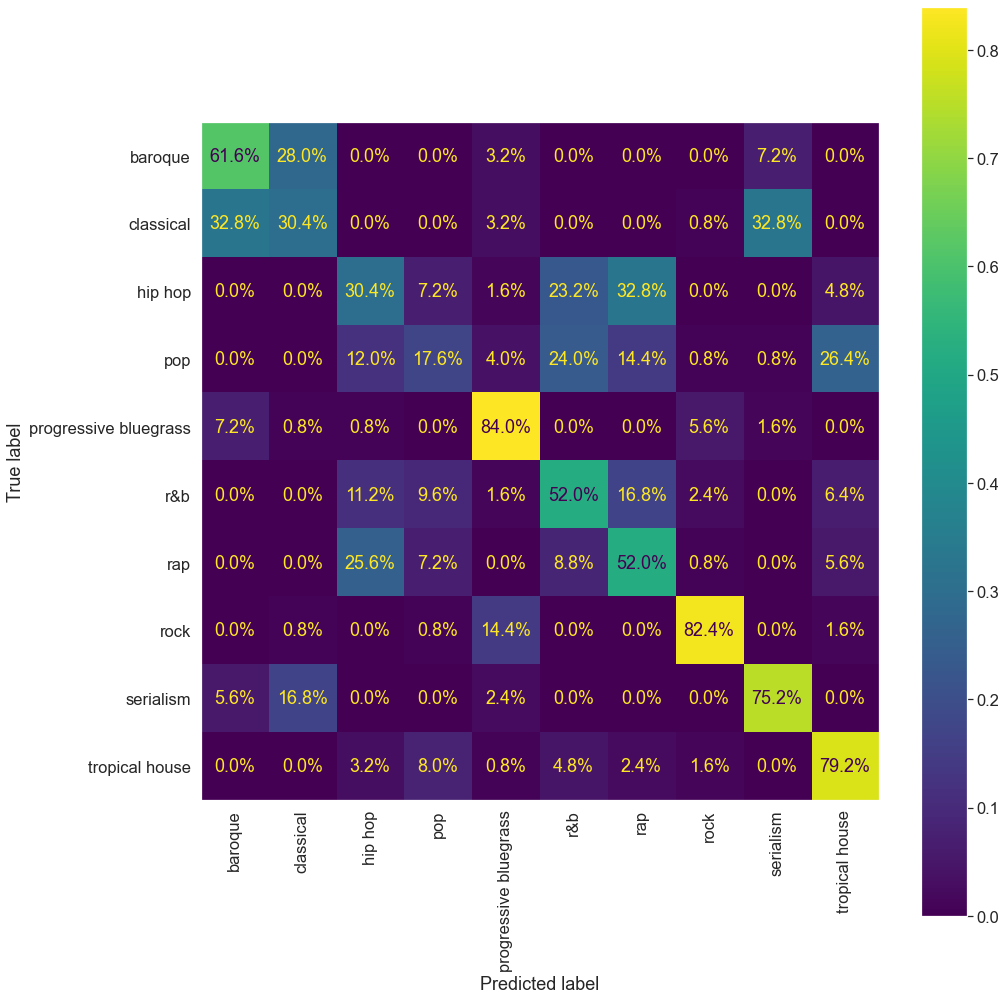

In [113]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.5)
plot_confusion_matrix(model, X_test, y_test, 
                      xticks_rotation='90', 
                      values_format='.1%', 
                      normalize='true', ax=ax)
plt.grid(False)
plt.tight_layout()
plt.savefig('./images/extracted_10g_confmatrix.png', dpi=72);

Interesting that **classical is now much less accurately predicted as classical** as compared to the 5-genre model using my features: now down to 30.4% from 95%.

Also, what this confusion matrix is good at showing us is **relationships between genres**. Note how hip hop, rap, r&b, and pop music seem to get confused for each other often. While 

In [40]:
results_wrong = results.copy()[results['genre'] != results['preds']]

In [41]:
songs_wrong = songs.loc[results_wrong.index, ['track_name']]

In [42]:
results_wrong['track_name'] = songs_wrong.copy()

## What songs were predicted wrong?

Let's dig in to what our model is having trouble predicting - we'll get more into this in the final notebook, but is there anything we can glean, initially?

In [43]:
results_wrong[(results_wrong['preds'] == 'r&b') & (results_wrong['genre'] == 'rap')].head()

,mean_energy,std_energy,min_energy,max_energy,max_rms,std_rms,median_rms,min_rms,mfcc_mean_00,mfcc_mean_01,...,mfcc_min_05,mfcc_min_06,mfcc_min_07,mfcc_min_08,mfcc_min_09,mfcc_min_10,mfcc_min_11,genre,preds,track_name
3195,24.843471,43.473087,0.711391,312.387702,0.781110,0.116883,0.156280,0.037275,-141.366699,133.685287,...,-20.908154,-35.137718,-27.743557,-29.407875,-26.499763,-27.540306,-25.050533,rap,r&b,Let Me Love You
3321,26.590519,29.747921,0.191029,273.605072,0.731016,0.110927,0.180929,0.019316,-133.751358,115.526764,...,-15.578063,-50.545280,-39.140114,-38.253895,-32.995163,-34.234432,-34.955311,rap,r&b,Only You (feat. The Notorious B.I.G. & Mase) -...
3165,47.097539,23.124728,1.186404,163.884424,0.565762,0.077898,0.299036,0.048137,-74.971954,114.833939,...,-24.593081,-79.668434,-25.795635,-51.206230,-33.526154,-35.183311,-32.016739,rap,r&b,"Lean Back (feat. Lil Jon, Eminem, Mase & Remy ..."
3245,29.673278,31.338210,0.298578,281.688644,0.741737,0.099919,0.205723,0.024149,-104.038696,130.311005,...,-15.830107,-53.566849,-32.964211,-33.709805,-41.523914,-34.184483,-26.018078,rap,r&b,How Could You
3335,60.966544,56.715459,0.013328,335.565174,0.809568,0.142688,0.282822,0.005102,-79.955498,124.234909,...,-5.862773,-69.910767,-28.862019,-38.025276,-47.551888,-29.548595,-38.075996,rap,r&b,Panini - DaBaby Remix


In my conclusions, I want to listen to some of the songs that were misclassified and determine what might be causing the misclassifications. **Is there something that I can hear as a feature to separate the genres?**

In [44]:
group_preds = results_wrong.groupby('preds').mean()

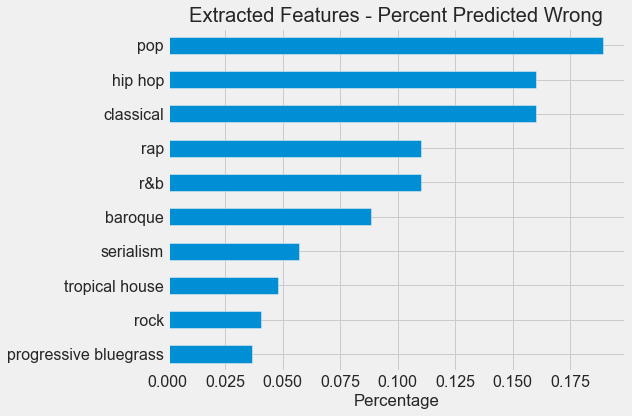

In [118]:
style.use('fivethirtyeight')
results_wrong['genre'].value_counts(normalize=True).sort_values().plot(kind='barh', title='Extracted Features - Percent Predicted Wrong', fontsize=16, figsize=(9,6))
plt.xlabel("Percentage")
plt.tight_layout()
plt.savefig('./images/incorrect_preds_10g_extracted.png', dpi=100);

Classical and pop are near the top of the list of "most incorrectly predicted". These genres are more generic genres with many subgenres underneath. It makes sense that the model wasn't able to predict well.

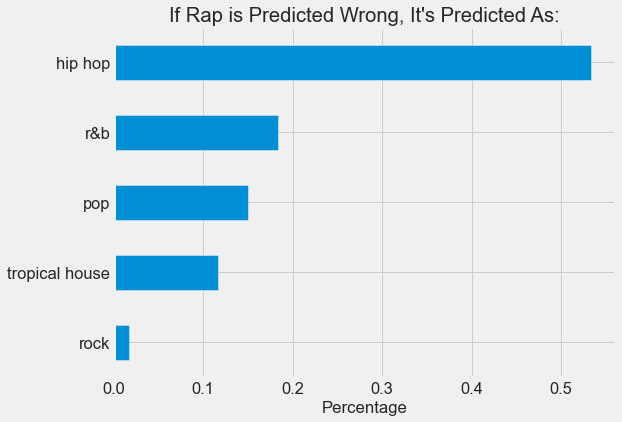

In [117]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(8,6))
plt.xlabel("Percentage")
plt.title("If Rap is Predicted Wrong, It's Predicted As:");

Contrary to the last model, **when rap is predicted wrong, it is most likely to be predicted as hip hop**. This means our 10-genre model more closely relates rap with hip hop. As a refresher, when our 5-genre model predicted rap wrong, it predicted it as r&b 100% of the time.

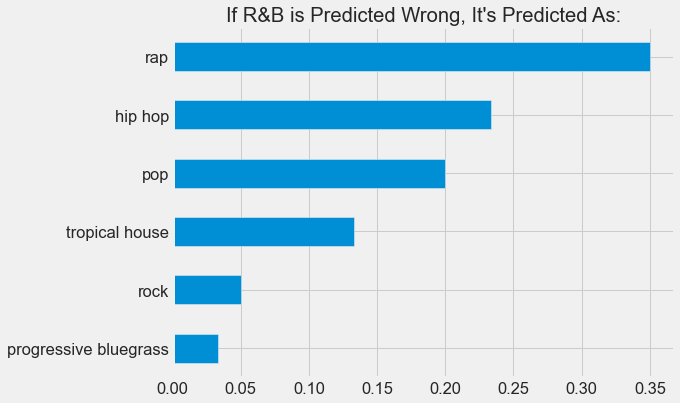

In [116]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(8,6))
plt.title("If R&B is Predicted Wrong, It's Predicted As:");

Contrary to the 5-genre model, **when R&B is predicted wrong, it's predicted to be rap only 35% of the time**, down from 84% of the time in the 5-genre model.

## Convolutional Neural Network

I've seen many people posting on the usefulness of CNNs for instrument and genre classification, and I wanted to try it out. Since Mel Frequency Cepstral Coefficients are used to generate spectrograms, they can be passed similarly to image data through a CNN.

In [50]:
cnn_df = songs[['mfcc_calc', 'genre']].explode('mfcc_calc')

In [51]:
def cnn_sequential_prep(data, column, rename_suffix, n_windows, drop=True):
    '''
    Picks sequential rows from data on a given column.
    Dataframe passed should include a calculation column
    and a categorical column.
    '''
    grouped = data.groupby(data.index).apply(lambda x: x.iloc[:n_windows]) # Group data by index
    grouped_tag = grouped.droplevel(0)[column].progress_apply(pd.Series) # Turns each item in array into its own column
    grouped_tag = grouped_tag.rename(columns = lambda x: rename_suffix + str(x)) # Rename columns so I know what they are
    final = pd.concat([grouped_tag[:], grouped.droplevel(0)[:]], axis=1) # Concatenate with original dataframe
    if drop:
        final.drop(columns=column)
    
    return final

In [52]:
# Some of my songs ended up being longer than 30 seconds, 
# so I had to reduce them all to the minimum number of windows (30 seconds)
cnn_df = songs['mfcc_calc'].apply(lambda x: x[:2584]) 

In [53]:
# Prepping the 2d mfcc_calcs to be passed through a CNN requires them
# to be separated into columns
for i in tqdm(range(len(cnn_df))):
    cnn_df[i] = np.array([coef for window in cnn_df[i] for coef in window])

100%|██████████| 4999/4999 [00:41<00:00, 120.33it/s]


In [54]:
# Let's split the lists into their own columns!
cnn_df = cnn_df.progress_apply(pd.Series)

100%|██████████| 4999/4999 [00:08<00:00, 618.70it/s]  


In [55]:
cnn_df = pd.concat([cnn_df[:], songs[['genre']]], axis=1) # Adding genre to this df

In [56]:
X = cnn_df.drop(columns='genre')
# Thanks joris on SO: https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969
y_cat = cnn_df['genre'].astype('category').cat.codes

In [57]:
y = to_categorical(y_cat) # One Hot Encoding y

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [59]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [60]:
# Scaling data for CNN
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Data needs to be reshaped to be the size of the mfcc spectrogram, which is 2584 x 12 x 1

In [61]:
X_train = X_train.reshape(X_train.shape[0], 2584, 12, 1)
X_test = X_test.reshape(X_test.shape[0], 2584, 12, 1)

In [62]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=6,
                     kernel_size=(4, 4),
                     activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2], 1)))

cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(filters=12,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2], 1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(10, activation='softmax'))

cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

hist = cnn_model.fit(X_train, y_train,
                epochs=30,
                batch_size=256,
                validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/30
15/15 [==============================] - 1s 64ms/step - loss: 2.3382 - acc: 0.0990 - val_loss: 2.2975 - val_acc: 0.1064
Epoch 2/30
15/15 [==============================] - 1s 43ms/step - loss: 2.2958 - acc: 0.1198 - val_loss: 2.2624 - val_acc: 0.1648
Epoch 3/30
15/15 [==============================] - 1s 43ms/step - loss: 2.2391 - acc: 0.1630 - val_loss: 2.1749 - val_acc: 0.2040
Epoch 4/30
15/15 [==============================] - 1s 42ms/step - loss: 2.1663 - acc: 0.1998 - val_loss: 2.0752 - val_acc: 0.1960
Epoch 5/30
15/15 [==============================] - 1s 43ms/step - loss: 2.0847 - acc: 0.2107 - val_loss: 1.9900 - val_acc: 0.2400
Epoch 6/30
15/15 [==============================] - 1s 43ms/step - loss: 2.0106 - acc: 0.2315 - val_loss: 1.8603 - val_acc: 0.2872
Epoch 7/30
15/15 [==============================] - 1s 40ms/step - loss: 1.9024 - acc: 0.2777 - val_loss: 1.7699 - val_acc: 0.3320
Epoch 8/30
15/15 [==============================] - 1s 41ms/step - loss: 1.8122 - a

The CNN model is not performing as well as the SVC model, it's **underperforming on testing data by about 3%**

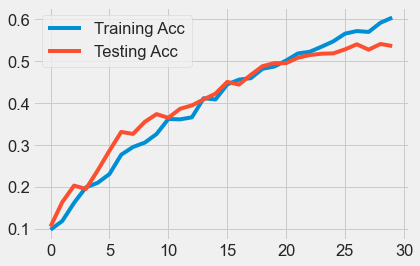

In [65]:
plt.plot(hist.history['acc'], label="Training Acc")
plt.plot(hist.history['val_acc'], label="Testing Acc")
plt.legend();

## What's next?

Next up: Investigation! We've done some great modeling and are outperforming the baseline model (models using Spotify features) by $\approx$ 5.9%, but I want to dig into the songs that we *aren't* predicting correctly and see if we can tell why.